In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
data = pd.read_csv('kvd_auction_20160404.csv', index_col = 0)
data.head()

,auction_URL,car_model,description,place_of_sale,estimated_auction_price,estimated_dealership_price,buyer_fee,auction_start,examiner_comment,equipment,...,export_allowed,new_car_price,nr_of_keys,import_type,created,object_number.1,auction_date,bidder,highest_bid,created.1
object_number,,,,,,,,,,,,,,,,,,,,,
713531,https://www.kvd.se/auktion/personbil/VW/Passat...,VW Passat,"1.4 TSI EcoFuel Variant (Aut, Helläder, 150hk)...",Malmö,42 000 kr - 52 000 kr,61 200 kr,3 125 kr,3/4 20:10,Kombi från Volkswagen med miljöklassad gasmoto...,"Klimatanläggning , Automat med möjlighet att v...",...,Ja,294 000 kr,2,Svensksåld,2016-03-31 04:15:27.614622+00,713531,2016-04-03,rs001,46 500 kr,2016-04-04 04:14:05.820771+00
711281,https://www.kvd.se/auktion/personbil/Toyota/iQ...,Toyota iQ,1.0 (68hk) -09,Kungälv,38 269 kr - 49 049 kr,53 900 kr,3 125 kr,3/4 20:12,Toyota iQ utrustad med driftsnål motor på 68hk...,"AC , ABS , Antisladdsystem , Fjärrlås , Motorv...",...,Ja,150 000 kr,2,Svensksåld,2016-03-31 04:15:24.984741+00,711281,2016-04-03,CarBuyerJ,35 101 kr,2016-04-04 04:14:18.898717+00
713373,https://www.kvd.se/auktion/personbil/Toyota/Au...,Toyota Auris,"1.6 VVT-i (Aut, 132hk) -09",Åkersberga,38 198 kr - 48 958 kr,53 800 kr,3 125 kr,3/4 20:14,"Auris, en trevlig och populär mellanklassmodel...","Klimatanläggning , Automat med möjlighet att v...",...,Ja,168 000 kr,3,Svensksåld,2016-03-31 04:15:23.703849+00,713373,2016-04-03,rodan2009,50 000 kr,2016-04-04 04:14:01.535805+00
708665,https://www.kvd.se/auktion/personbil/Volvo/V40...,Volvo V40,"D2 (Aut, 115hk)(Rep.objekt) -15",Växjö,24 000 kr - 28 750 kr,194 600 kr,3 125 kr,3/4 20:16,"Volvo V40 som säljes som reparationsobjekt, se...","Automat med möjlighet att växla manuellt , ABS...",...,Ja,242 000 kr,1,Svensksåld,2016-03-31 04:15:19.49412+00,708665,2016-04-03,juliatal,44 000 kr,2016-04-04 04:14:05.734501+00
712178,https://www.kvd.se/auktion/personbil/Toyota/Ve...,Toyota Verso,"S 1.33 (Aut, Backkamera, 99hk) -13",Åkersberga,35 642 kr - 45 682 kr,50 200 kr,3 125 kr,3/4 20:18,Toyota Verso utrustad med automatlåda och back...,"AC , Automat med möjlighet att växla manuellt ...",...,Ja,182 000 kr,2,Svensksåld,2016-03-31 04:15:17.429783+00,712178,2016-04-03,bilkompanietuppsala,47 211 kr,2016-04-04 04:14:05.825906+00


In [9]:
data.shape

(3041, 72)

In [14]:
data.dtypes

auction_URL                             object
car_model                               object
description                             object
place_of_sale                           object
estimated_auction_price                 object
estimated_dealership_price              object
buyer_fee                               object
auction_start                           object
examiner_comment                        object
equipment                               object
registration_number                     object
model_year                               int64
milage                                  object
manufactured_date                      float64
first_time_in_traffic                   object
service_book                            object
transmission                            object
nr_of_seats                              int64
color                                   object
car_paint                               object
fabric                                 float64
new_car_warra

In [22]:
data['highest_bid'].replace('[^0-9]+.-', '', regex=True)
data['highest_bid'][:10]

object_number
713531     46 500 kr
711281     35 101 kr
713373     50 000 kr
708665     44 000 kr
712178     47 211 kr
714671     36 000 kr
710486     33 500 kr
714086     15 001 kr
710670     77 500 kr
714774    120 000 kr
Name: highest_bid, dtype: object

TypeError: 'float' object is not iterable

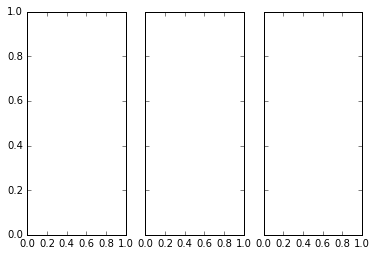

In [11]:
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='estimated_dealership_price', y='highest_bid', ax=axs[0], figsize=(16.8))
data.plot(kind='scatter', x='new_car_price', y='highest_bid', ax=axs[1])
data.plot(kind='scatter', x='place_of_sale', y='highest_bid', ax=axs[2])